In this first notebook, we will go from the installation of the [Brian](http://briansimulator.org/) neural simulator to the display of the simulation of an Hodgkin-Huxley neuron.

We will now explore some examples of their [tutorials](https://brian2.readthedocs.io/en/stable/resources/tutorials/index.html)

In [1]:
import brian2 as sim

In [2]:
help(sim.core)

Help on package brian2.core in brian2:

NAME
    brian2.core

DESCRIPTION
    Essential Brian modules, in particular base classes for all kinds of brian
    objects.
    
    Built-in preferences
    --------------------
    .. document_brian_prefs:: core

PACKAGE CONTENTS
    base
    clocks
    core_preferences
    functions
    magic
    names
    namespace
    network
    operations
    preferences
    spikesource
    tracking
    variables

FILE
    /usr/local/lib/python3.7/site-packages/brian2/core/__init__.py




In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig_width = 15
phi = (np.sqrt(5)+1)/2

# the simplest neuron in the world


## Units system

Brian has a system for using quantities with physical dimensions:

In [4]:
20*sim.volt

20. * volt

All of the basic SI units can be used (volt, amp, etc.) along with all the standard prefixes (m=milli, p=pico, etc.), as well as a few special abbreviations like ``mV`` for millivolt, ``pF`` for picofarad, etc.

In [5]:
1000*sim.amp

1. * kamp

In [6]:
1e6*sim.volt

1. * Mvolt

In [7]:
1000*sim.namp

1. * uamp

Also note that combinations of units with work as expected:

In [8]:
10*sim.nA*5*sim.Mohm

50. * mvolt

## A simple model

Let's start by defining a simple neuron model. 

In [9]:
sim.start_scope()

tau = 10*sim.ms
v0 = 42*sim.volt
eqs = '''
dv/dt = (v0-v)/tau : volt
'''

G = sim.NeuronGroup(1, eqs)
M = sim.StateMonitor(G, 'v', record=True)

sim.run(100*sim.ms)

WARNING    /usr/local/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/laurentperrinet/Library/Caches/cython/brian_extensions/_cython_magic_aa9c1e222c6ff2fb81458e0dc96cba87.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
 [py.warnings]
sh: line 1: 53462 Abort trap: 6           /Applications/Xcode.app/Contents/Developer/usr/bin/xcodebuild -sdk macosx -find clang++ 2> /dev/null
clang++: error: unable to find utility "clang++", not a developer tool or in PATH
WARNING    Cannot use Cython, a test compilation failed: command 'clang++' failed with exit status 72 (LinkError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message

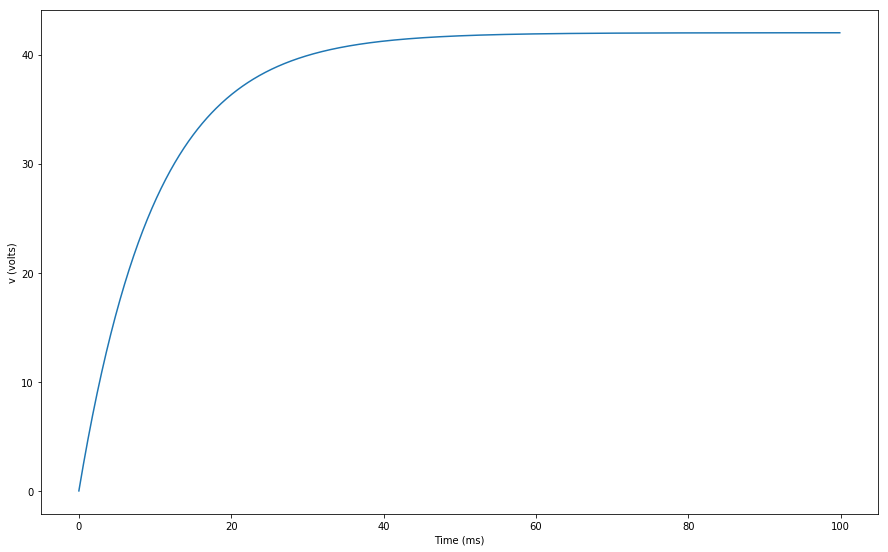

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(M.t/sim.ms, M.v[0])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('v (volts)');

## Adding spikes

So far we haven't done anything neuronal, just played around with differential equations. Now let's start adding spiking behaviour.

In [11]:
sim.start_scope()

tau = 10*sim.ms
v0 = 1.2*sim.volt
eqs = '''
dv/dt = (v0-v)/tau : volt
'''

G = sim.NeuronGroup(1, eqs, threshold='v>0.8*volt', reset='v=0*volt', refractory=5*sim.ms)
M = sim.StateMonitor(G, 'v', record=True)
spikemon = sim.SpikeMonitor(G)

sim.run(100*sim.ms)


INFO       No numerical integration method specified for group 'neurongroup_1', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]


In [12]:
print('Spike times: %s' % spikemon.t[:])

Spike times: [10.9 21.9 32.9 43.9 54.9 65.9 76.9 87.9 98.9] ms


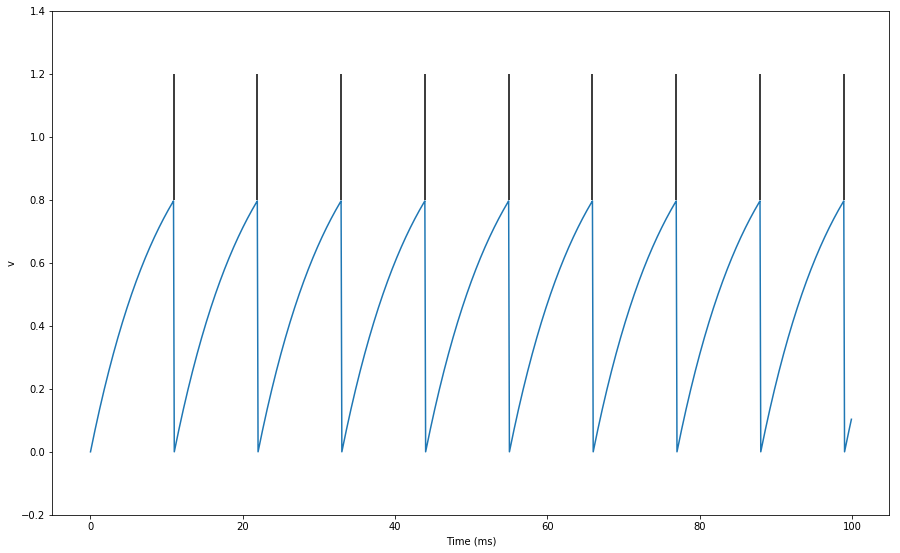

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(M.t/sim.ms, M.v[0])
for t in spikemon.t:
    ax.vlines(t/sim.ms, ymin=.8, ymax=1.2)
ax.set_xlabel('Time (ms)')
ax.set_ylim(-.2, 1.4)
ax.set_ylabel('v');

### Hodgkin-Huxley cells (without morphology)

code adapted from https://brian2.readthedocs.io/en/stable/examples/IF_curve_Hodgkin_Huxley.html  (morphology added in  https://brian2.readthedocs.io/en/stable/examples/compartmental.hodgkin_huxley_1952.html ).

In [14]:
sim.start_scope()

duration = .2*sim.second

# Parameters
area = 20000*sim.umetre**2
Cm = 1*sim.ufarad*sim.cm**-2 * area
gl = 5e-5*sim.siemens*sim.cm**-2 * area
El = -65*sim.mV
EK = -90*sim.mV
ENa = 50*sim.mV
g_na = 100*sim.msiemens*sim.cm**-2 * area
g_kd = 30*sim.msiemens*sim.cm**-2 * area
VT = -63*sim.mV

# The model
HH_eqs = sim.Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
''')
# Threshold and refractoriness are only used for spike counting
HH_G = sim.NeuronGroup(1, HH_eqs,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')

In [15]:
HH_G.v

<neurongroup.v: array([0.]) * volt>

In [16]:
HH_G.v = El
HH_G.I = '0.7*nA'

HH_M = sim.StateMonitor(HH_G, 'v', record=True)

sim.run(duration)

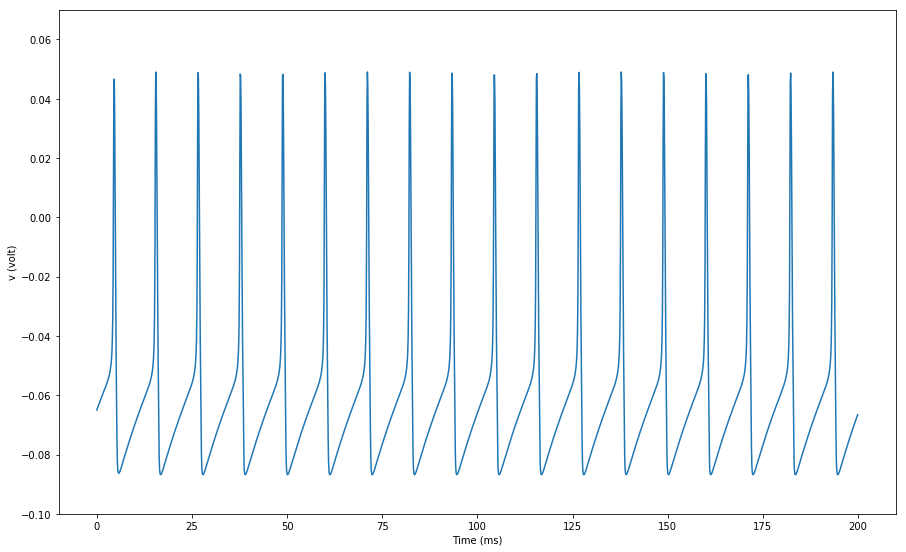

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
ax.plot(HH_M.t/sim.ms, HH_M.v[0])
ax.set_xlabel('Time (ms)')
ax.set_ylim(-.1, .07)
ax.set_ylabel('v (volt)');

In [18]:
fig.savefig('figures/HH_firing.png')